# Anomaly Detection

In [1]:
# Install the library we need for the notebook
!pip3 install --user 'fim'
!pip3 install --user 'pysbrl'
!pip install --user 'git+https://github.com/hlin117/mdlp-discretization'
!pip install --user 'ruleset'
!pip install --user 'imbalanced-learn' 

You are using pip version 18.0, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.0, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Cloning https://github.com/hlin117/mdlp-discretization to /tmp/pip-req-build-pal673a4
  Running setup.py bdist_wheel for mdlp-discretization ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-6851i3r8/wheels/54/a5/2d/fbdb21ce01bf7fe06c23d4a1d225d33d192184afe38dc8d400
Successfully built mdlp-discretization
You are using pip version 18.0, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.0, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.0, however version 19.1.1 is available.
You should consider upgrading via the 

In [1]:
import os
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import math as mt
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import bokeh as bk
import time
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score
from ruleset import *
from imblearn.combine import SMOTEENN
from collections import Counter
from mdlp.discretization import MDLP
from pysbrl import BayesianRuleList


base = "/mnt/datasets/anomaly/"

/mnt/workspace/.local/lib/python3.5/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
#Read the dataset and load it as a pandas dataframe
anomalyDF = pd.read_csv(base+"data.csv", sep=";")

#Update name of the columns
anomalyDF.columns = ['SessionNumber','SystemID','Date','HighPriorityAlerts','Dumps','CleanupOOMDumps',
                     'CompositeOOMDumps','IndexServerRestarts','NameServerRestarts','XSEngineRestarts',
                     'PreprocessorRestarts','DaemonRestarts','StatisticsServerRestarts','CPU','PhysMEM',
                     'InstanceMEM','TablesAllocation','IndexServerAllocationLimit','ColumnUnloads',
                     'DeltaSize','MergeErrors','BlockingPhaseSec','Disk','LargestTableSize',
                     'LargestPartitionSize','DiagnosisFiles','DiagnosisFilesSize','DaysWithSuccessfulDataBackups',
                     'DaysWithSuccessfulLogBackups','DaysWithFailedDataBackups','DaysWithFailedLogBackups',
                     'MinDailyNumberOfSuccessfulDataBackups','MinDailyNumberOfSuccessfullLogBackups',
                     'MaxDailyNumberOfFailedDataBackups','MaxDailyNumberOfFailedLogBackups',
                     'LogSegmentChange','Check1','Check2','Check3','Check4','Check5','Check6','Check7','Check8']
# Print the size of the training set
print("Size of training set : "+str(len(anomalyDF)))
print("\n")

#Show some samples
anomalyDF[:5]

Size of training set : 287030




,SessionNumber,SystemID,Date,HighPriorityAlerts,Dumps,CleanupOOMDumps,CompositeOOMDumps,IndexServerRestarts,NameServerRestarts,XSEngineRestarts,...,MaxDailyNumberOfFailedLogBackups,LogSegmentChange,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8
0,1,1,06/02/2017 04:03,0,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,2,1,20/02/2017 04:03,0,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,3,2,13/02/2017 04:44,1,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,4,3,06/02/2017 04:31,1,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,5,4,06/02/2017 04:33,1,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


## 1. Data Exploration

We will first cast each column to its respective type.

In [3]:
print(anomalyDF.dtypes)

SessionNumber                              int64
SystemID                                   int64
Date                                      object
HighPriorityAlerts                         int64
Dumps                                    float64
CleanupOOMDumps                          float64
CompositeOOMDumps                        float64
IndexServerRestarts                        int64
NameServerRestarts                         int64
XSEngineRestarts                           int64
PreprocessorRestarts                       int64
DaemonRestarts                             int64
StatisticsServerRestarts                   int64
CPU                                      float64
PhysMEM                                  float64
InstanceMEM                              float64
TablesAllocation                         float64
IndexServerAllocationLimit               float64
ColumnUnloads                              int64
DeltaSize                                float64
MergeErrors         

The type of some columns is float64 even though it should be int64 according to the dataset description, so we will cast them to the correst type.

In [4]:
# Cast each column to its correct datatype
for label in anomalyDF.columns[anomalyDF.dtypes=="int64"].tolist() :
    anomalyDF[label] = anomalyDF[label].astype(np.int64)
for label in anomalyDF.columns[anomalyDF.dtypes=="float64"].tolist() :
    anomalyDF[label] = anomalyDF[label].astype(np.float64)
    
anomalyDF["Date"] = pd.to_datetime(anomalyDF["Date"],infer_datetime_format=True)

We get a error when trying to cast the columns as int64 because they contain NaN values, which cannot be casted to int. We will handle this problem after dealing with missing values.

#### Missing values

In [5]:
# Compute number of missing values per attribute in the training set
dataSize = len(anomalyDF)
print("Size of training set : "+str(dataSize))
for label in anomalyDF.columns : 
    value_count = anomalyDF[label].count()
    if value_count != dataSize  :
        print("  Number of missing values in "+label+" in training dataset : "+str(dataSize-value_count))
print("\n")

Size of training set : 287030
  Number of missing values in Dumps in training dataset : 3
  Number of missing values in CleanupOOMDumps in training dataset : 3
  Number of missing values in CompositeOOMDumps in training dataset : 3
  Number of missing values in CPU in training dataset : 25209
  Number of missing values in PhysMEM in training dataset : 20567
  Number of missing values in InstanceMEM in training dataset : 22117
  Number of missing values in TablesAllocation in training dataset : 2290
  Number of missing values in IndexServerAllocationLimit in training dataset : 26443
  Number of missing values in DeltaSize in training dataset : 206
  Number of missing values in MergeErrors in training dataset : 7733
  Number of missing values in BlockingPhaseSec in training dataset : 75853
  Number of missing values in Disk in training dataset : 11379
  Number of missing values in LargestTableSize in training dataset : 16250
  Number of missing values in LargestPartitionSize in training 

There are missing values in some of the features. We can handle that by using different methods to impute missing values such as replacing them by the mean, median, the next value or the value of the last observation. We will drop the 3 observations with missing values regarding dumps because they are only a small subset of the dataset.
The way we choose to handle missing values is dependent on the nature of the dataset and the model we will use : replacing by the mean or median value is suited when using linear models but not tree-based models. It is better to replace by the mean value for a continuous variable without outliers, and replacing by the median value is better when there are outliers. 

There are also missing values in the labels we aim to predict. We will not take observations with missing value for the target into consideration when training our model, and there should still be enough observations. It could be a problem if we try to train a multi-label classifier, because the number of observation without any missing label could be too small. We could counter this problem by imputing missing values with a one-label classifier before training our multi-label classifier.

#### Descriptive statistics

In [6]:
nb_obs = len(anomalyDF)
for i in range (1,9):
    name = "Check"+str(i)
    print("Likelihood of occurence of "+name+": "+str(anomalyDF[name].sum()/anomalyDF[name].count()))
    print("\n")

Likelihood of occurence of Check1: 0.006231929879361113


Likelihood of occurence of Check2: 0.03338107136327625


Likelihood of occurence of Check3: 0.030601749967859276


Likelihood of occurence of Check4: 0.09910777046456642


Likelihood of occurence of Check5: 0.01222236772659992


Likelihood of occurence of Check6: 0.2881214106405956


Likelihood of occurence of Check7: 0.030591942954462253


Likelihood of occurence of Check8: 0.01017151140505544




The anomalies we want to predict concern between a ratio between 0.006 and 0.29 of the observations. Most of them concern far less than 1 out of 100 observations. For the most imbalanced labels, we might need to use undersampling or oversampling to create a balanced training dataset so that our model does not assume that every observation is normal. 
To evaluate the performance of our algorithm, we will use a metric called Cohen's Kappa score. It expresses the degree of agreement between two estimators and varies between 0 and 1, 0 meaning acomplete disagreement and 1 a perfect agreement.
Cohen's kappa score is well suited to assess the performance of binary classification with imbalanced classes.

Then we will plot the distributions of the features.

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


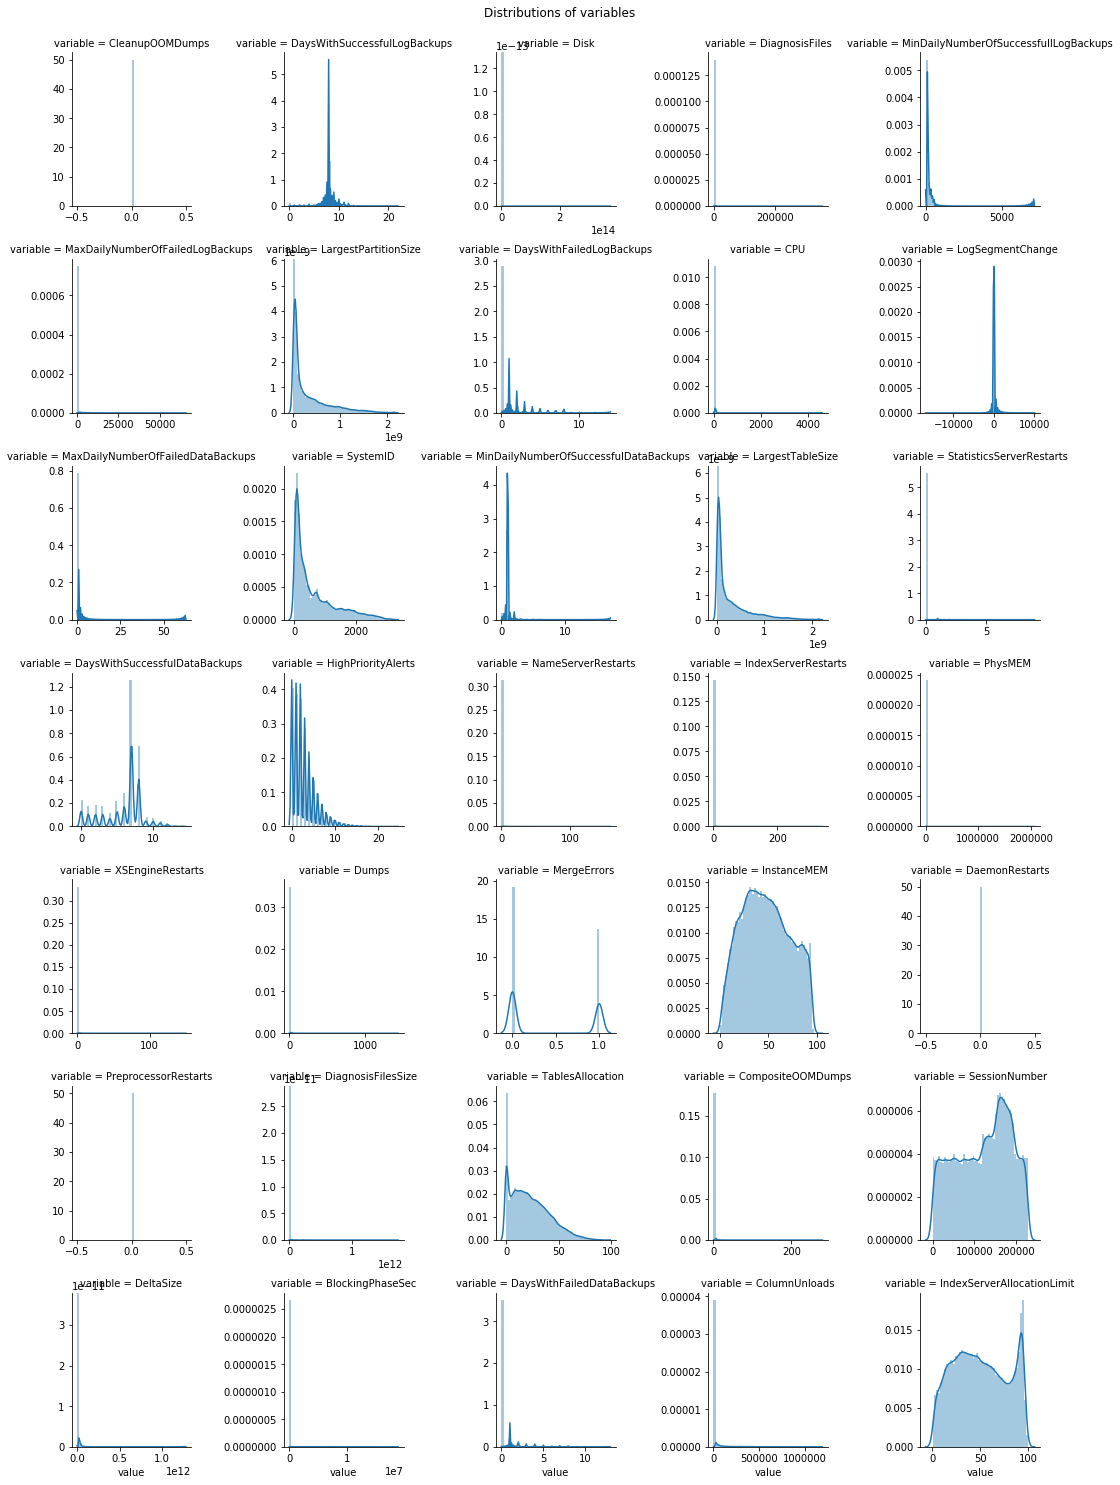

In [19]:
#Select quantitative columns
qua_columns = list(set(anomalyDF.select_dtypes('number').columns)-{'Check1','Check2','Check3','Check4','Check5','Check6','Check7','Check8'})

#Plot histogram and kde for those columns
f = pd.melt(anomalyDF, value_vars=qua_columns)
g = sns.FacetGrid(f, col='variable',  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Distributions of variables');

#### Outliers
Looking at those plots, we can see that some columns such as DiagnosisFiles or ColumnUnloads seem to contain outliers, because some observations are way outside of the usual range of those variables. Those outliers could be of significant interest since we want to detect anomalies, so we will keep them for now.
CPU, PhysMEM, InstanceMEM,TablesAllocation and IndexServerAllocationLimit are supposed to be floats between 0 and 100, yet we can see from their histogram that some values of PhysMEM and CPU are outside that range. We will replace the values exceeding 100 by 100.

In [7]:
anomalyDF.loc[anomalyDF['PhysMEM']>100,'PhysMEM'] = 100
anomalyDF.loc[anomalyDF['CPU']>100,'CPU'] = 100

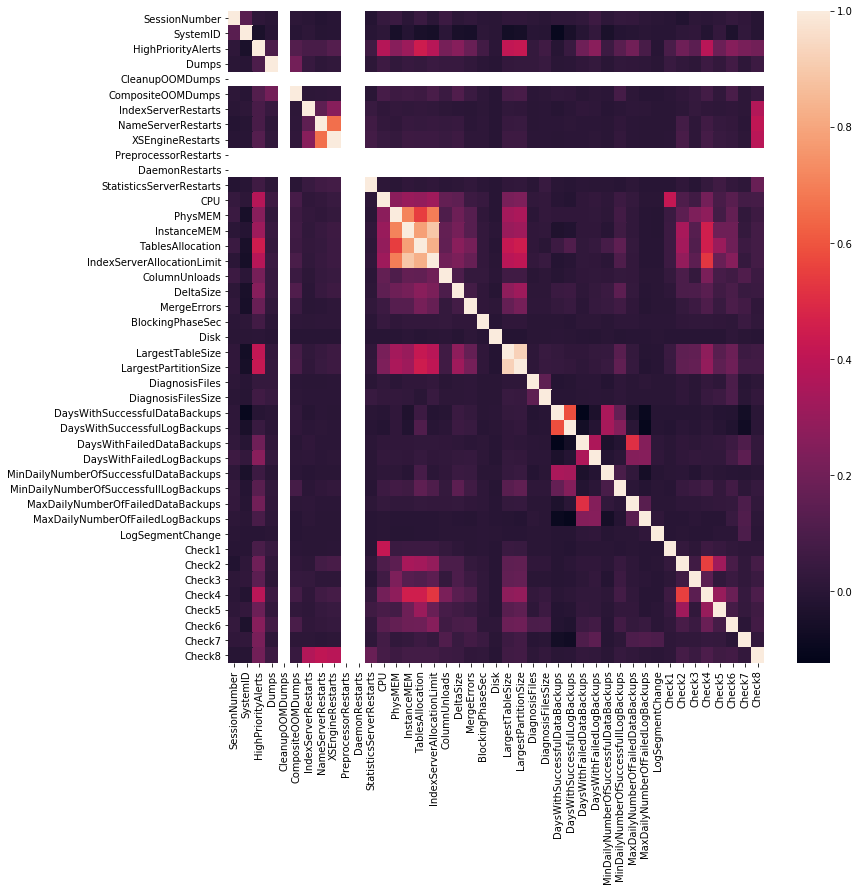

In [45]:
#Print correlation map of all features and labels 
corrmat = anomalyDF.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat);

We can see that the feature HighPriorityAlerts is correlated with all our labels, which makes sense since the labels are supposed to represent anomalies.

The values regarding CleanupOOMDumps, PreprocessorRestarts and DaemonRestarts in the correlation matrix are NaN because they have a constant value. Because of that, those columns do not hold any predictive power, so we will drop them before training our model.

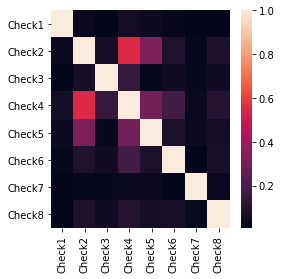

In [38]:
#Print correlation map of labels 
corrmat = anomalyDF[['Check1','Check2','Check3','Check4','Check5','Check6','Check7','Check8']].corr()
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(corrmat);

Check2, Check4 and Check5 are quite strongly correlated one to the other. Check1 is the only one that is not correlated to any of the others. The correlation between the different labels might be used by a multi-label classifier, but if we train different models separately for each label we might use them less.

#### Dealing with missing values

Here we choose to replace missing values by the mean values of the respective columns.

In [8]:
# Compute number of missing values per attribute in the training set
print("Size of training set : "+str(dataSize))
for label in anomalyDF.columns : 
    value_count = anomalyDF[label].count()
    if value_count != dataSize  :
        print("  Number of missing values in "+label+" in training dataset : "+str(dataSize-value_count))
print("\n")

Size of training set : 287030
  Number of missing values in Dumps in training dataset : 3
  Number of missing values in CleanupOOMDumps in training dataset : 3
  Number of missing values in CompositeOOMDumps in training dataset : 3
  Number of missing values in CPU in training dataset : 25209
  Number of missing values in PhysMEM in training dataset : 20567
  Number of missing values in InstanceMEM in training dataset : 22117
  Number of missing values in TablesAllocation in training dataset : 2290
  Number of missing values in IndexServerAllocationLimit in training dataset : 26443
  Number of missing values in DeltaSize in training dataset : 206
  Number of missing values in MergeErrors in training dataset : 7733
  Number of missing values in BlockingPhaseSec in training dataset : 75853
  Number of missing values in Disk in training dataset : 11379
  Number of missing values in LargestTableSize in training dataset : 16250
  Number of missing values in LargestPartitionSize in training 

Since columns with integer and NaN values are of type float, we have to select integer columns 'manually' according to the dataset description, so we can replace missing values by the nearest integer to the mean of the columns, rather than the mean itself.

In [9]:
#List of labels of integer columns with missing values
int_columns = ['DeltaSize','BlockingPhaseSec','LargestTableSize','LargestPartitionSize',
              'DiagnosisFiles','DiagnosisFilesSize','MaxDailyNumberOfFailedDataBackups',
              'MaxDailyNumberOfFailedLogBackups','LogSegmentChange','MergeErrors']

for label in int_columns : 
    anomalyDF[label] = anomalyDF[label].fillna(int(round(anomalyDF[label].mean())))

#Drop the 3 observations with missing value for Dumps features
anomalyDF = anomalyDF.dropna(subset=['Dumps','CleanupOOMDumps','CompositeOOMDumps'])

#Replace missing float values with mean
for label in anomalyDF.columns :
    value_count = anomalyDF[label].count()
    if value_count != dataSize and 'Check' not in label : 
        #Replace missing float values with mean
        if anomalyDF[label].dtype == 'float64' :
            anomalyDF[label] = anomalyDF[label].fillna(anomalyDF[label].mean())

In [10]:
miscasted_features = ["DeltaSize","MergeErrors","BlockingPhaseSec","Disk","LargestTableSize","LargestPartitionSize","DiagnosisFiles",
"DiagnosisFilesSize","MaxDailyNumberOfFailedDataBackups","MaxDailyNumberOfFailedLogBackups",
"LogSegmentChange"]
for label in miscasted_features : 
    anomalyDF[label] = anomalyDF[label].astype(np.int64)

In [11]:
# Compute number of missing values per attribute in the training set
print("Size of training set : "+str(dataSize))
for label in anomalyDF.columns : 
    value_count = anomalyDF[label].count()
    if value_count+3 != dataSize  :
        print("  Number of missing values in "+label+" in training dataset : "+str(dataSize-value_count))
print("\n")

Size of training set : 287030
  Number of missing values in Check1 in training dataset : 24514
  Number of missing values in Check2 in training dataset : 24489
  Number of missing values in Check3 in training dataset : 22571
  Number of missing values in Check4 in training dataset : 36648
  Number of missing values in Check5 in training dataset : 35035
  Number of missing values in Check6 in training dataset : 7387
  Number of missing values in Check7 in training dataset : 35725
  Number of missing values in Check8 in training dataset : 55




We can then assert that no columns except for the labels have any missing value.

In [12]:
assert not anomalyDF.drop(['Check1','Check2','Check3','Check4','Check5','Check6','Check7','Check8'],axis=1).isna().values.any()

#### Encoding date data

We will encode the Date column as time in seconds since the earliest date in our dataset

In [13]:
anomalyDF['TimePassed'] = pd.to_timedelta(anomalyDF['Date']-anomalyDF['Date'].min())
anomalyDF['TimePassed'] = anomalyDF['TimePassed'].apply(lambda date : int(date.total_seconds()))
print(anomalyDF['TimePassed'][:5])
anomalyDF = anomalyDF.drop('Date',axis=1)

0    13040100
1     4227300
2     3624960
3    13041780
4    13041900
Name: TimePassed, dtype: int64


#### Dropping irrelevant columns

In [14]:
anomalyDF = anomalyDF.drop(['CleanupOOMDumps','PreprocessorRestarts','DaemonRestarts'],axis=1)

## 3. Model Selection

In [16]:
# To compare models
performance=pd.DataFrame(columns= ['target','Model','Accuracy','F1-score','training time','interpretability'])

In [16]:
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = pd.DataFrame(X)
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

transformer = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
            ('scaler', StandardScaler()) #Should we scale ?
        ])),  # floats close

      # features close
])  # pipeline close

In [30]:
print(anomalyDF.dtypes)

SessionNumber                              int64
SystemID                                   int64
HighPriorityAlerts                         int64
Dumps                                    float64
CompositeOOMDumps                        float64
IndexServerRestarts                        int64
NameServerRestarts                         int64
XSEngineRestarts                           int64
StatisticsServerRestarts                   int64
CPU                                      float64
PhysMEM                                  float64
InstanceMEM                              float64
TablesAllocation                         float64
IndexServerAllocationLimit               float64
ColumnUnloads                              int64
DeltaSize                                  int64
MergeErrors                                int64
BlockingPhaseSec                           int64
Disk                                       int64
LargestTableSize                           int64
LargestPartitionSize

### Logistic regression

First, a simple one-label classifier

We will first try to train a simple Logistic Regression model to predict each label individually. We will try for each to train our model with a balanced dataset or the original one to see the difference in performance.

In [16]:
logisticPredictor = Pipeline([('transform', transformer),
                                    ('classifier', LogisticRegression(max_iter=1000,random_state=42, solver='lbfgs'))])

In [57]:
#target : string, design the Check to predict
#balance : boolean, True if the training dataset is balanced before training, using undersampling
# return the trained model and its associated cohen_kappa_score
def train_logistic_regression(target, df, balance=False):
    # Create the list of labels we do not predict to drop them
    labels = ['Check1','Check2','Check3','Check4','Check5','Check6','Check7','Check8']
    labels.remove(target)
    trainDF = df.drop(labels,axis=1)
    
    # Drop rows with missing values for target column
    trainDF = trainDF.dropna(subset=[target])
    
    #Split training and testing dataset 80%-20%
    msk = np.random.rand(len(trainDF)) < 0.8
    testDF = trainDF[~msk]
    trainDF = trainDF[msk]

    if balance :     #Subsample normal observations of the training dataset
        normal_indices = trainDF[trainDF[target] == 0].index
        nb_anomaly = len(trainDF[trainDF[target] == 1])
        random_indices = np.random.choice(normal_indices, nb_anomaly, replace=False)
        normal_samples = trainDF.loc[random_indices]
        trainDF = pd.concat([normal_samples,trainDF[trainDF[target] == 1]])
        
    #Split target and features
    X_train, Y_train = trainDF.drop([target],axis=1), trainDF[target]
    X_test, Y_test = testDF.drop([target],axis=1), testDF[target]
    
    start = time.time()
    
    #Fit our model
    logisticPredictor.fit(X_train,Y_train)
    
    end = time.time()
    print ('Training took :'+str(end-start))
    preds = logisticPredictor.predict(X_test)
    score = cohen_kappa_score(Y_test, preds)
    print(target+' cohen kappa score :'+str(score))   
    print("\n")
    
    return(logisticPredictor,score)
        

In [58]:
labels = ['Check1','Check2','Check3','Check4','Check5','Check6','Check7','Check8']
balanced_predictor_list = []
unbalanced_predictor_list = []
print('Predictors trained on balanced data :')
print('\n')
for label in labels :
    balanced_predictor_list.append(train_logistic_regression(label,anomalyDF,balance=True))
print('Predictors trained on unbalanced data :')
print('\n')
for label in labels :    
    unbalanced_predictor_list.append(train_logistic_regression(label,anomalyDF))

    

Predictors trained on balanced data :


Training took :0.056990861892700195
Check1 cohen kappa score :0.4824554775969382


Training took :0.4179205894470215
Check2 cohen kappa score :0.6897223633966978


Training took :0.4474782943725586
Check3 cohen kappa score :0.5334341078225048


Training took :0.7691051959991455
Check4 cohen kappa score :0.9044062410181439


Training took :0.09090900421142578
Check5 cohen kappa score :0.23743839991811733


Training took :13.478346824645996
Check6 cohen kappa score :0.8431537975962831


Training took :0.1427454948425293
Check7 cohen kappa score :0.14069815649161954


Training took :0.12238216400146484
Check8 cohen kappa score :0.6838573002275072


Predictors trained on unbalanced data :


Training took :11.996945142745972
Check1 cohen kappa score :0.913835613334127


Training took :5.723270893096924
Check2 cohen kappa score :0.9023393131621152


Training took :6.737347841262817
Check3 cohen kappa score :0.7223088538927714


Training took :6.5723202

We obtain better results for every anomaly excepting Check4 when we train our model without first undersampling in order to balance the number of normal and abnormal observations. Because the original ratio of normal and abnormal observations is so high, undersampling to a 1:1 ratio loses a lot of potentially useful data. 
We will try to find a compromise by testing different ration for our training dataset.

#### Random Undersampling

In [49]:
def undersampled_dataset(target, trainDF, ratio):
        normal_indices = trainDF[trainDF[target] == 0].index
        nb_anomaly = len(trainDF[trainDF[target] == 1])
        random_indices = np.random.choice(normal_indices, nb_anomaly * ratio, replace=False)
        normal_samples = trainDF.loc[random_indices]
        return pd.concat([normal_samples,trainDF[trainDF[target] == 1]])
    

In [50]:
def prepared_dataset_for_training(target, df, balance=False, ratio=-1):
    # Create the list of labels we do not predict to drop them
    labels = ['Check1','Check2','Check3','Check4','Check5','Check6','Check7','Check8']
    labels.remove(target)
    trainDF = df.drop(labels,axis=1)
    
    # Drop rows with missing values for target column
    trainDF = trainDF.dropna(subset=[target])
    
    #Split training and testing dataset 80%-20%
    msk = np.random.rand(len(trainDF)) < 0.8
    testDF = trainDF[~msk]
    trainDF = trainDF[msk]
    
    if balance :     #Undersample normal observations of the training dataset
        normal_indices = trainDF[trainDF[target] == 0].index
        nb_anomaly = len(trainDF[trainDF[target] == 1])
        if nb_anomaly * ratio < len(normal_indices) :
            trainDF = undersampled_dataset(target, trainDF, ratio)
        else :
            print('ratio '+str(ratio)+' exceeded number of normal observations')
    
    #Split target and features
    X_train, y_train = trainDF.drop([target],axis=1), trainDF[target]
    X_test, y_test = testDF.drop([target],axis=1), testDF[target]
    
    return (X_train,y_train,X_test,y_test)

            


In [36]:
#target : string, design the Check to predict
#balance : boolean, True if the training dataset is balanced before training, using undersampling
#ratio : integer, ratio of normal and abnormal observations 
# return the trained model and its associated cohen_kappa_score
def train_logistic_regression_ratio(target, df, balance=False, ratio=-1):
    X_train, y_train, X_test, y_test = prepared_dataset_for_training(target, df, balance, ratio)
    
    start = time.time()
    
    #Fit our model
    logisticPredictor.fit(X_train,Y_train)
    
    end = time.time()
    print ('Training took :'+str(end-start))
    
    #Predict label of testing set
    preds = logisticPredictor.predict(X_test)
    score = cohen_kappa_score(y_test, preds)
    print(target+' cohen_kappa-score with ratio '+str(ratio)+': '+str(score))   
    print("\n")
    
    return(logisticPredictor,score)
        

In [51]:
labels = ['Check1','Check2','Check3','Check4','Check5','Check6','Check7','Check8']
#keys : labels , values : list of tuples (ratio,model,score) with different ratios
predictorsDict = dict()
for label in labels :
    predictorsDict[label] = []
for label in labels :
    for ratio in [1,2,3,5,10] :
            predictorsDict[label].append((ratio,train_logistic_regression_ratio(label,anomalyDF,True,ratio)))
    predictorsDict[label].append((-1,train_logistic_regression_ratio(label,anomalyDF))) # -1 ratio means no undersampling


NameError: name 'logisticPredictor' is not defined

### Changer ce texte

The optimal ratio of normal and abnormal observations varies with the anomaly we aim to detect. In the next steps, we will use for each label the best ratio we found, that is : 1 for Check4, 5 for Check5, 10  for Check1 and Check2, and unbalanced for Check2 and Check6. 
Choosing a good ratio of normal and abnormal observations can lead to a significant increase in the f1-score of our model : compared to the models trained on the original dataset, we gain 4% for Check4 or 6% for Check5 for example. Yet too much undersampling leads to worse performance, as we can see with Check6 which drops from 100% with the original training set to 83% when we undersample to a 1:1 ratio.

In [108]:
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn import svm

class SparseToDenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.toarray()

def train_default_estimators(X_train,Y_train,X_test,Y_test) :
    #Train several classifier with default parameters on (X_train,Y_train), print their scores on (X_test_Y_test) and return array of estimators
    #For now, gradientBoosting, gaussianProcess and Logistic Regression do not work, might be added in the future
    svmPredictor = Pipeline([('transform', transformer),
                                   ('classifier', SGDClassifier(max_iter=1000))])
    start = time.time()
    svmPredictor.fit(X_train ,Y_train)
#     print("SVM")
    end = time.time()
#     print ('Training took :'+str(end-start))

    preds = svmPredictor.predict(X_test)
    cohen_kappa = cohen_kappa_score(Y_test, preds)
    f1=f1_score(Y_test, preds, average='macro')
    accuracy= accuracy_score(Y_test, preds)
    

    svmDF.loc[len(svmDF)]=[labels[i],ratios[j],accuracy,f1,cohen_kappa,end-start]
    
#     print("cohen_kappa_score",cohen_kappa)    
#     print("\n")
#     print('f1_score', f1)    
#     print("\n")
#     print("accuracy",accuracy)    
#     print("\n")
    
    
    randomForestPredictor = Pipeline([('transform', transformer),
                                   ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))])
    start = time.time()
    
    #Fit our model
    randomForestPredictor.fit(X_train ,Y_train)
#     print("Random Forest")
        
    end = time.time()
#     print ('Training took :'+str(end-start))
    
    preds = randomForestPredictor.predict(X_test)
    cohen_kappa = cohen_kappa_score(Y_test, preds)
    f1=f1_score(Y_test, preds, average='macro')
    accuracy= accuracy_score(Y_test, preds)
    randomForestDF.loc[len(randomForestDF)]=[labels[i],ratios[j],accuracy,f1,cohen_kappa,end-start]
#     print(score)    
#     print("\n")
    
    logisticPredictor = Pipeline([('transform', transformer),
                                    ('classifier', LogisticRegression(max_iter=1000,random_state=42, solver='lbfgs'))])
    
    start = time.time()

    logisticPredictor.fit(X_train ,Y_train)
#     print("Logistic Regression")
    
    end = time.time()
#     print ('Training took :'+str(end-start))
    
    preds = logisticPredictor.predict(X_test)
    cohen_kappa = cohen_kappa_score(Y_test, preds)
    f1=f1_score(Y_test, preds, average='macro')
    accuracy= accuracy_score(Y_test, preds)
    logisticDF.loc[len(logisticDF)]=[labels[i],ratios[j],accuracy,f1,cohen_kappa,end-start]
#     score = cohen_kappa_score(Y_test, preds)
#     print(score)    
#     print("\n")
    
    ridgePredictor = Pipeline([('transform', transformer),
                                   ('classifier', RidgeClassifier())])
    start = time.time()

    ridgePredictor.fit(X_train ,Y_train)
#     print("Ridge")
    
    end = time.time()
#     print ('Training took :'+str(end-start))
    
    preds = ridgePredictor.predict(X_test)
    cohen_kappa = cohen_kappa_score(Y_test, preds)
    f1=f1_score(Y_test, preds, average='macro')
    accuracy= accuracy_score(Y_test, preds)
    ridgeDF.loc[len(ridgeDF)]=[labels[i],ratios[j],accuracy,f1,cohen_kappa,end-start]
#     score = cohen_kappa_score(Y_test, preds)
#     print(score)    
#     print("\n")


    passiveAggressivePredictor = Pipeline([('transform', transformer),
                                    ('classifier', PassiveAggressiveClassifier(max_iter=1000))])
    start = time.time()

    passiveAggressivePredictor.fit(X_train ,Y_train)
#     print("Passive-Aggressive")
    
    end = time.time()
#     print ('Training took :'+str(end-start))
    
    preds = passiveAggressivePredictor.predict(X_test)
    cohen_kappa = cohen_kappa_score(Y_test, preds)
    f1=f1_score(Y_test, preds, average='macro')
    accuracy= accuracy_score(Y_test, preds)
    passiveAggressiveDF.loc[len(passiveAggressiveDF)]=[labels[i],ratios[j],accuracy,f1,cohen_kappa,end-start]
#     score = cohen_kappa_score(Y_test, preds)
#     print(score)    
#     print("\n")


    sgdPredictor = Pipeline([('transform', transformer),
                                    ('classifier', SGDClassifier(max_iter=1000))])
    start = time.time()

    sgdPredictor.fit(X_train ,Y_train)
#     print("SGD")
    
    end = time.time()
#     print ('Training took :'+str(end-start))
    preds = sgdPredictor.predict(X_test)
    cohen_kappa = cohen_kappa_score(Y_test, preds)
    f1=f1_score(Y_test, preds, average='macro')
    accuracy= accuracy_score(Y_test, preds)
    sgdDF.loc[len(sgdDF)]=[labels[i],ratios[j],accuracy,f1,cohen_kappa,end-start]
#     score = cohen_kappa_score(Y_test, preds)
#     print(' cohen_kappa_score', score)    
#     print("\n")
    
    
    return [randomForestPredictor, logisticPredictor, ridgePredictor, passiveAggressivePredictor, sgdPredictor]

i,j=0,0
ratios=['imbalanced',1,10,50]
svmDF=pd.DataFrame( columns= ['label','ratio','Accuracy','F1-score','cohen_kappa_score','training time'])
randomForestDF=pd.DataFrame( columns= ['label','ratio','Accuracy','F1-score','cohen_kappa_score','training time'])
logisticDF=pd.DataFrame( columns= ['label','ratio','Accuracy','F1-score','cohen_kappa_score','training time'])
ridgeDF=pd.DataFrame( columns= ['label','ratio','Accuracy','F1-score','cohen_kappa_score','training time'])
passiveAggressiveDF=pd.DataFrame( columns=['label','ratio','Accuracy','F1-score','cohen_kappa_score','training time'])
sgdDF=pd.DataFrame( columns= ['label','ratio','Accuracy','F1-score','cohen_kappa_score','training time'])

for label in labels :
    print('cohen_kappa-score of default estimators on '+label+' with unbalanced training set :')
    X_train, y_train, X_test, y_test = prepared_dataset_for_training(label,anomalyDF)
    native_estimators = train_default_estimators(X_train, y_train, X_test, y_test)
    j=(j+1)%4
    for ratio in [1,10,50] :
        print('cohen_kappa-score of default estimators on '+label+' with ratio '+str(ratio)+' :')
        X_train, y_train, X_test, y_test = prepared_dataset_for_training(label,anomalyDF, True , ratio)
        native_estimators = train_default_estimators(X_train, y_train, X_test, y_test)
        j=(j+1)%4
        
    i=(i+1)%8


cohen_kappa-score of default estimators on Check1 with unbalanced training set :


/mnt/workspace/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


cohen_kappa-score of default estimators on Check1 with ratio 1 :
cohen_kappa-score of default estimators on Check1 with ratio 10 :
cohen_kappa-score of default estimators on Check1 with ratio 50 :
cohen_kappa-score of default estimators on Check2 with unbalanced training set :
cohen_kappa-score of default estimators on Check2 with ratio 1 :
cohen_kappa-score of default estimators on Check2 with ratio 10 :
cohen_kappa-score of default estimators on Check2 with ratio 50 :
ratio 50 exceeded number of normal observations
cohen_kappa-score of default estimators on Check3 with unbalanced training set :
cohen_kappa-score of default estimators on Check3 with ratio 1 :
cohen_kappa-score of default estimators on Check3 with ratio 10 :
cohen_kappa-score of default estimators on Check3 with ratio 50 :
ratio 50 exceeded number of normal observations
cohen_kappa-score of default estimators on Check4 with unbalanced training set :
cohen_kappa-score of default estimators on Check4 with ratio 1 :
cohen

In [109]:
# Keep best ratios 
#SVM
idx = svmDF.groupby(['label'])['F1-score'].transform(max) == svmDF['F1-score']
svmDF=svmDF[idx]

#RandomForest
idx = randomForestDF.groupby(['label'])['F1-score'].transform(max) == randomForestDF['F1-score']
randomForestDF=randomForestDF[idx]

#logistic
idx = logisticDF.groupby(['label'])['F1-score'].transform(max) == logisticDF['F1-score']
logisticDF=logisticDF[idx]

#ridge
idx = ridgeDF.groupby(['label'])['F1-score'].transform(max) == ridgeDF['F1-score']
ridgeDF=ridgeDF[idx]

#passiveAggressiveDF
idx = passiveAggressiveDF.groupby(['label'])['F1-score'].transform(max) == passiveAggressiveDF['F1-score']
passiveAggressiveDF=passiveAggressiveDF[idx]

#sgdDF
idx = sgdDF.groupby(['label'])['F1-score'].transform(max) == sgdDF['F1-score']
sgdDF=sgdDF[idx]


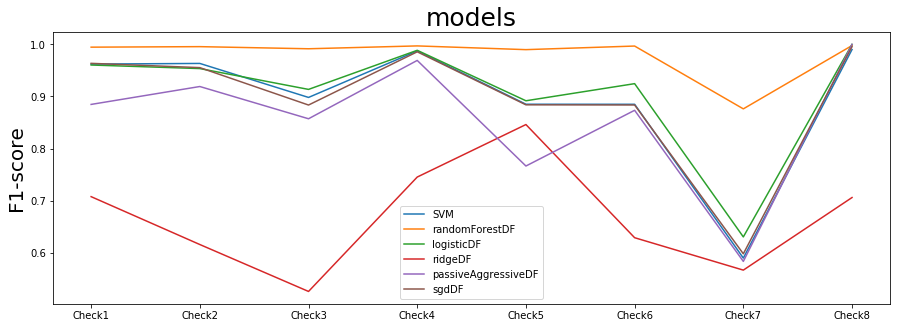

In [110]:
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.set_ylabel('F1-score', fontsize=20)
plt.title('models', fontsize=25)
ax.plot(svmDF['label'],svmDF['F1-score'], label = 'SVM')
ax.plot(randomForestDF['label'],randomForestDF['F1-score'], label = 'randomForestDF')
ax.plot(logisticDF['label'],logisticDF['F1-score'], label = 'logisticDF')
ax.plot(ridgeDF['label'],ridgeDF['F1-score'], label = 'ridgeDF')
ax.plot(passiveAggressiveDF['label'],passiveAggressiveDF['F1-score'], label = 'passiveAggressiveDF')
ax.plot(sgdDF['label'],sgdDF['F1-score'], label = 'sgdDF')
ax.legend()



#### SMOTE + ENN sampling
Undersampling the majority class like we did until now has the advantage of reducing the amount of training data and thus the computation time to train our model. Yet, undersampling involves discarding potentially useful data. We will try to address this issue by using a combination of undersampling the majority class using the Edited Nearest Neighbors algorithm (ENN) and oversampling the minority class using  Synthetic Minority Oversampling Technique (SMOTE). This is the combination that yields the best results in a paper titled 'Survey of resampling techniques for improving
classification performance in unbalanced datasets' by Ajinkya More [1]. The author of this paper compares metrics in the case of a problem with the foolowing features :
1. A large number of instances need to be evaluated.
2. The minority class is present in a small fraction of the
instances.
3. Only instances flagged as minority class (by an automated classification system) will be reviewed manually.
4. The cost of manual review is significantly lower relativeto the cost of a missed detection of the minority class.

This approach will increase the training time compared to undersampling, but it should give us better results.

In [65]:
sme = SMOTEENN(random_state=42)

def prepared_dataset_for_training_smote_een(target, df):
    # Create the list of labels we do not predict to drop them
    labels = ['Check1','Check2','Check3','Check4','Check5','Check6','Check7','Check8']
    labels.remove(target)
    trainDF = df.drop(labels,axis=1)
    
    # Drop rows with missing values for target column
    trainDF = trainDF.dropna(subset=[target])
    
    #Split training and testing dataset 80%-20%
    msk = np.random.rand(len(trainDF)) < 0.8
    testDF = trainDF[~msk]
    trainDF = trainDF[msk]
    
    #Use SMOTE + EEN to resample data
    start = time.time()
    print('Original dataset shape for '+target+'  %s' % Counter(trainDF[target]))
    X_train, y_train = sme.fit_resample(trainDF.drop(target,axis=1), trainDF[target])
    end = time.time()
    print('Resampled dataset shape %s' % Counter(y_train))
    print('Resampling took '+str(end-start)+' seconds')
    X_test, y_test = testDF.drop([target],axis=1), testDF[target]
    
    return (X_train,y_train,X_test,y_test)
    
    

In [66]:
#target : string, design the Check to predict
#balance : boolean, True if the training dataset is balanced before training, using undersampling
#ratio : integer, ratio of normal and abnormal observations 
# return the trained model and its associated cohen_kappa_score
def train_logistic_regression_smote_een(target, df):
    X_train, y_train, X_test, y_test = prepared_dataset_for_training_smote_een(target, df)
    #Fit our model
    logisticPredictor.fit(X_train,y_train)
    
    #Predict label of testing set
    preds = logisticPredictor.predict(X_test)
    score = cohen_kappa_score(y_test, preds)
    print(target+' cohen_kappa-score with SMOTE + EEN sampling: '+str(score))   
    print("\n")
    
    return(logisticPredictor,score)

We will try this technique on Check7, as it is the label for which we have the worst performance for now.

In [67]:
X_train, y_train, X_test, y_test = prepared_dataset_for_training_smote_een('Check7',anomalyDF)
native_estimators = train_default_estimators(X_train, y_train, X_test, y_test)

Original dataset shape for Check7  Counter({0.0: 194572, 1.0: 6159})
Resampled dataset shape Counter({1.0: 179738, 0.0: 158685})
Resampling took :80.55388355255127 seconds
Random Forest
Training took :192.91375946998596
0.7340170049841095


Logistic Predictor
Training took :6.654243469238281
0.1329322473152642


Ridge
Training took :1.0474891662597656
0.13374696113465534


Passive-Aggressive
Training took :1.4955646991729736
0.08615664565660741


SGD
Training took :2.6337268352508545
0.12697477289175352




In [71]:
corrmat['Check7']

SessionNumber                            0.019485
SystemID                                 0.024332
HighPriorityAlerts                       0.221668
Dumps                                    0.013981
CompositeOOMDumps                        0.011196
IndexServerRestarts                      0.010963
NameServerRestarts                       0.007034
XSEngineRestarts                         0.010051
StatisticsServerRestarts                 0.014489
CPU                                      0.075821
PhysMEM                                  0.024583
InstanceMEM                              0.034504
TablesAllocation                         0.055097
IndexServerAllocationLimit               0.037832
ColumnUnloads                            0.112714
DeltaSize                                0.045975
MergeErrors                              0.071589
BlockingPhaseSec                         0.047847
Disk                                     0.001362
LargestTableSize                         0.056078


In [76]:
import operator
features = anomalyDF.drop(labels,axis=1).columns
feature_importances_dict = dict()
for i in range(len(features)) :
    feature_importances_dict[features[i]]=randomForestPredictor.named_steps['classifier'].feature_importances_[i]
sorted_features = sorted(feature_importances_dict.items(), key=operator.itemgetter(1))
print(sorted_features)

[('StatisticsServerRestarts', 0.0003990298042423996), ('NameServerRestarts', 0.001412317685477102), ('XSEngineRestarts', 0.0015084626224187076), ('Disk', 0.001538332793567751), ('IndexServerRestarts', 0.002514755899150279), ('CompositeOOMDumps', 0.003443639421348471), ('MinDailyNumberOfSuccessfulDataBackups', 0.003776918917418711), ('MergeErrors', 0.005545815113231985), ('MaxDailyNumberOfFailedDataBackups', 0.005724313109203084), ('Dumps', 0.00614213297707131), ('DaysWithFailedDataBackups', 0.00749071287598005), ('DaysWithFailedLogBackups', 0.01575711423333799), ('DaysWithSuccessfulDataBackups', 0.015872119470160095), ('DaysWithSuccessfulLogBackups', 0.019476593270121197), ('ColumnUnloads', 0.02062539565678773), ('MaxDailyNumberOfFailedLogBackups', 0.023054874630886055), ('TimePassed', 0.026032935296091634), ('InstanceMEM', 0.028214499664023028), ('TablesAllocation', 0.02846713410255726), ('SessionNumber', 0.028531677346857215), ('IndexServerAllocationLimit', 0.029322914282399307), ('B

#### Deep Learning classifier for Check7

In [89]:
from keras.utils import to_categorical
X_train, y_train, X_test, y_test = prepared_dataset_for_training('Check7',anomalyDF)

In [90]:
import keras.backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [97]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

#create model
model = Sequential()

#get number of columns in training data
n_cols = X_train.shape[1]

#add model layers
model.add(Dense(1000, activation='relu', input_shape=(n_cols,)))
model.add(Dense(1000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(1,activation='relu'))

#compile model using cohen's kappa score as a measure of model performance
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #accuracy is no good

start = time.time()
#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=3)
#train model
model.fit(X_train, y_train, validation_split=0.2, epochs=30, callbacks=[early_stopping_monitor])
end=time.time()
print('Training took '+str(end-start)+' seconds.')


Train on 160770 samples, validate on 40193 samples
Epoch 1/30
160770/160770 [==============================] - 133s 830us/step - loss: 0.4980 - acc: 0.9691 - val_loss: 0.4656 - val_acc: 0.9711
Epoch 2/30
160770/160770 [==============================] - 133s 827us/step - loss: 0.4980 - acc: 0.9691 - val_loss: 0.4656 - val_acc: 0.9711
Epoch 3/30
160770/160770 [==============================] - 132s 819us/step - loss: 0.4980 - acc: 0.9691 - val_loss: 0.4656 - val_acc: 0.9711
Epoch 4/30
160770/160770 [==============================] - 132s 820us/step - loss: 0.4980 - acc: 0.9691 - val_loss: 0.4656 - val_acc: 0.9711
Training took 530.6971278190613 seconds.


In [ ]:
predictions = model.predict(X_test)
print(predictions[:10])
score = cohen_kappa_score(y_test, predictions)
print('Check7 cohen_kappa-score : '+str(score))   

## 4. Parameters optimization

In [42]:
randomForestPredictor = Pipeline([('transform', transformer),
                        ('classifier', RandomForestClassifier(random_state=42, n_estimators=200))])
print(randomForestPredictor.get_params())

{'classifier__oob_score': False, 'transform__features__scaler__with_std': True, 'transform__features__scaler__with_mean': True, 'classifier__criterion': 'gini', 'transform__features__scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'steps': [('transform', Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=1,
                              transformer_list=[('scaler',
                                                 StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True))],
                              transformer_weights=None, verbose=False))],
         verbose=False)), ('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_spli

#### Bayesian Optimization

We will try to optimize the hyperparameters of our Random Forest models using bayesian optimization implemented in the python package hyperopt-sklearn.

The hyperparameters we want to optimize are the following : 
- max_features : controls the maximum number of features considered for a split. 
The default parameter is equal to the square root of number of features.
- max_depth : controls the maximum depth of the trees. 
- class_weight : controls the weight given to the two classes of our labels.
We will try two values for this parameter : None and 'balanced', which gives a weight inversely proportional to the frequency of each class.

In [27]:
from hpsklearn import HyperoptEstimator, random_forest, standard_scaler
from hyperopt import tpe
optiEstim = HyperoptEstimator( preprocessing=[standard_scaler('scaler')],
                                          classifier=random_forest('myRForest'), algo=tpe.suggest, max_evals=150)

In [ ]:
optimizedModels = dict()
for label in {'Check7'} : 
    #Prepare dataset
    X_train, y_train, X_test, y_test = prepared_dataset_for_training(label,anomalyDF)
    #Convert to numpy array for Hyperopt
    X_train, y_train, X_test, y_test = X_train.values, y_train.values, X_test.values, y_test.values
    start = time.time()
    optiEstim.fit(X_train ,y_train)
    end = time.time()
    print ('Training took :'+str(end-start))
    preds = optiEstim.predict(X_test)
    score = f1_score(Y_test, preds)
    print(score)    
    print("\n")
    optimizedModels[label] = optiEstim

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

In [ ]:
for label in labels : 
    X_train, y_train, X_test, y_test = prepared_dataset_for_training(label,anomalyDF)
    start = time.time()
    optiEstim.fit(X_train ,y_train)
    end = time.time()
    print ('Training took :'+str(end-start))
    preds = optiEstim.predict(X_test)
    score = f1_score(Y_test, preds)
    print(score)    
    print("\n")
    optimizedModels[label] = optiEstim

### Rule-based models

### Scalable Bayesian Rule list 

Bayesian Rule list is an algorithm that allows building probabilistic rule lists. The logical structure of these lists is a sequence of IF-THEN rules, (identical to a decision list or one-sided decision tree).

In [ ]:
#Le training s'est arrêté au check6, je continue les 3 qui manquent, après on enleve cette partie pour tout train 
def compute_intervals(mdlp_discretizer):
    category_names = []
    for i in mdlp_discretizer.cut_points_:
        cut_points = mdlp_discretizer.cut_points_[i]
        idxs = np.arange(len(cut_points) + 1)
        names = mdlp_discretizer._assign_intervals(idxs, i)
        category_names.append(names)
    return category_names

def test_BayesianRuleList(dataset,target):
    x, y = dataset,target
    
    x=x.astype(np.int)
    y=y.astype(np.int)
    feature_names = dataset.columns
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.33, random_state=42)
    discretizer = MDLP(random_state=42).fit(x_train, y_train)
    x_train_cat = discretizer.transform(x_train)
    category_names = compute_intervals(discretizer)
    rule_list = BayesianRuleList(seed=1, feature_names=feature_names, category_names=category_names)
    rule_list.fit(x_train_cat, y_train, verbose = 2)
    print(rule_list.rule_list)
    x_test_cat = discretizer.transform(x_test)
    y_pred=rule_list.predict(discretizer.transform(x_test))
    
    print('acc: %.4f' % rule_list.score(x_test_cat, y_test))
    print('f1_score', f1_score(y_test,y_pred))
    
    
labels = ['Check1','Check2','Check3','Check4','Check5','Check6','Check7','Check8']
for label in labels:
    print(label)
    test_BayesianRuleList(anomalyDF.dropna(subset=[label]).drop(['Check1','Check2','Check3','Check4','Check5','Check6','Check7','Check8'],axis=1),anomalyDF.dropna(subset=[label])[label])
    print("\n")

Check1
Info: sbrl data files saved to /tmp/tmpom7_77et and /tmp/tmptjuafjin temporarily
Info: time for rule mining: 45.3427s
Info: training time: 454.1261s
[Rule(clauses=[Clause(feature_idx=9, category=0)], output=array([9.99988552e-01, 1.14475416e-05])), Rule(clauses=[Clause(feature_idx=10, category=0), Clause(feature_idx=2, category=1)], output=array([0.6, 0.4])), Rule(clauses=[Clause(feature_idx=22, category=1)], output=array([0.01315789, 0.98684211])), Rule(clauses=[Clause(feature_idx=15, category=5), Clause(feature_idx=20, category=5)], output=array([0.30434783, 0.69565217])), Rule(clauses=[Clause(feature_idx=17, category=2)], output=array([0.02769231, 0.97230769])), Rule(clauses=[Clause(feature_idx=21, category=0)], output=array([0.01298701, 0.98701299])), Rule(clauses=[Clause(feature_idx=18, category=2), Clause(feature_idx=3, category=0)], output=array([0.02666667, 0.97333333])), Rule(clauses=[Clause(feature_idx=15, category=5), Clause(feature_idx=4, category=1)], output=array([

In [ ]:
#Le training s'est arrêté au check6, je continue les 3 qui manquent, après on enleve cette partie pour tout train 
def compute_intervals(mdlp_discretizer):
    category_names = []
    for i in mdlp_discretizer.cut_points_:
        cut_points = mdlp_discretizer.cut_points_[i]
        idxs = np.arange(len(cut_points) + 1)
        names = mdlp_discretizer._assign_intervals(idxs, i)
        category_names.append(names)
    return category_names

def test_BayesianRuleList(dataset,target):
    x, y = dataset,target
    
    x=x.astype(np.int)
    y=y.astype(np.int)
    feature_names = dataset.columns
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.33, random_state=42)
    discretizer = MDLP(random_state=42).fit(x_train, y_train)
    x_train_cat = discretizer.transform(x_train)
    category_names = compute_intervals(discretizer)
    rule_list = BayesianRuleList(seed=1, feature_names=feature_names, category_names=category_names)
    rule_list.fit(x_train_cat, y_train, verbose = 2)
    print(rule_list.rule_list)
    x_test_cat = discretizer.transform(x_test)
    y_pred=rule_list.predict(discretizer.transform(x_test))
    
    print('acc: %.4f' % rule_list.score(x_test_cat, y_test))
    print('f1_score', f1_score(y_test,y_pred))
    
    
labels = ['Check7','Check8', 'Check6']
for label in labels:
    print(label)
    test_BayesianRuleList(anomalyDF.dropna(subset=[label]).drop(['Check1','Check2','Check3','Check4','Check5','Check6','Check7','Check8'],axis=1),anomalyDF.dropna(subset=[label])[label])
    print("\n")

Check7
Info: sbrl data files saved to /tmp/tmpl14q8v5y and /tmp/tmp3mm7hwbf temporarily
Info: time for rule mining: 101.7143s
Info: training time: 1296.3408s
[Rule(clauses=[Clause(feature_idx=11, category=0), Clause(feature_idx=31, category=10)], output=array([0.15541922, 0.84458078])), Rule(clauses=[Clause(feature_idx=2, category=6), Clause(feature_idx=31, category=1)], output=array([0.57894737, 0.42105263])), Rule(clauses=[Clause(feature_idx=15, category=0), Clause(feature_idx=31, category=0)], output=array([0.72302158, 0.27697842])), Rule(clauses=[Clause(feature_idx=14, category=4), Clause(feature_idx=31, category=1)], output=array([0.25663717, 0.74336283])), Rule(clauses=[Clause(feature_idx=31, category=12)], output=array([0.04117647, 0.95882353])), Rule(clauses=[Clause(feature_idx=24, category=1), Clause(feature_idx=31, category=9)], output=array([0.17112299, 0.82887701])), Rule(clauses=[Clause(feature_idx=31, category=10), Clause(feature_idx=8, category=0)], output=array([0.05917

The time needed for SBRL algorithm to run is between 10 - 20 mins per label, which is more than the other algorithms we tried until now. The output contoins a number of rules varying from some 20 rules to around 140 rules per label .  The results are as good as the other (even better than some). And most important we havethe rules which explain the output of the algorithm.

### Models discussion 

Globally, We can notice that the rule-based models allowed us to have as good results, as the non rule-based both on accuracy and f1-score.

We would argue that the first competitor of the rule-based learning are the tree based algorithms: Indeed both are interpretable and offer a very good results. In our case the randomForest algorithm was better both on complexity level (training time) and the quality of results (F1-score). 

Rule based learning is useful when machine learning tools are used as a decision aid to humans, who need to understand the model in order to trust it and make data-driven decisions.